# 1. Batch normalization (2 points)

Please make use of the model code from Homework 5 question 2 as you work on this question.

1. If your model didn't use batch normalization, add it. If it already had batch normalization, remove it. How does the performance change? Please experiment with different learning rate values, since batch normalization can allow a different range of learning rates to work. You are welcome to write your own batch norm implementaiton or use a pre-existing one from mxnet or pytorch.
1. Plot the squared L2 norm of gradients with respect to parameters over the course of training with and without batch normalization. To do this, you will need to compute the gradient of the loss over some data with respect to each parameter, square these gradients, and sum the result across all parameters. You can compute this value at each training step, or after each epoch. What difference does batch normalization make in terms of the squared L2 norm of gradients?

**Without Batch Normalization**

In [1]:
# Import packages
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):

    def __init__(self):
        
        super(Net, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout2d(p=0.05, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Drop

In [5]:
import torch.optim as optim
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [6]:
# number of epochs to train the model
n_epochs = [*range(30)]
#List to store loss to visualize
train_losslist = []
valid_loss_min = np.Inf # track change in validation loss
# Initialize a list to store the squared L2 norms of gradients
avg_gradient_norms = []

for epoch in range(1, len(n_epochs)+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    # grad_norm = 0.0
    total_norm = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

        grad_norm = 0.0
        parameters = [p for p in model.parameters() if p.grad is not None and p.requires_grad]
        for p in parameters:
          param_norm = p.grad.detach().data.norm(2)
          grad_norm += param_norm.item() ** 2
      
        total_norm += grad_norm

    avg_gradient_norms.append(total_norm/len(train_loader.dataset))
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losslist.append(train_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.700323 	Validation Loss: 0.355365
Validation loss decreased (inf --> 0.355365).  Saving model ...
Epoch: 2 	Training Loss: 1.229372 	Validation Loss: 0.317885
Validation loss decreased (0.355365 --> 0.317885).  Saving model ...
Epoch: 3 	Training Loss: 0.928425 	Validation Loss: 0.201465
Validation loss decreased (0.317885 --> 0.201465).  Saving model ...
Epoch: 4 	Training Loss: 0.705682 	Validation Loss: 0.169071
Validation loss decreased (0.201465 --> 0.169071).  Saving model ...
Epoch: 5 	Training Loss: 0.556907 	Validation Loss: 0.165307
Validation loss decreased (0.169071 --> 0.165307).  Saving model ...
Epoch: 6 	Training Loss: 0.441992 	Validation Loss: 0.138353
Validation loss decreased (0.165307 --> 0.138353).  Saving model ...
Epoch: 7 	Training Loss: 0.358184 	Validation Loss: 0.148486
Epoch: 8 	Training Loss: 0.288999 	Validation Loss: 0.154857
Epoch: 9 	Training Loss: 0.248102 	Validation Loss: 0.166914
Epoch: 10 	Training Loss: 0.201062 	Valida

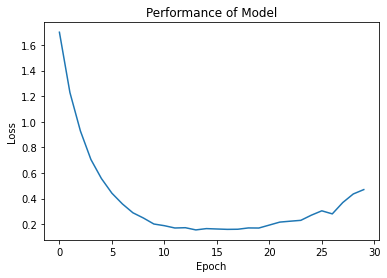

In [7]:
plt.plot(n_epochs, train_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model")
plt.show()

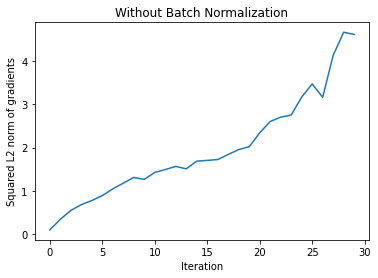

In [8]:
plt.plot(avg_gradient_norms)
plt.xlabel("Iteration")
plt.ylabel("Squared L2 norm of gradients")
plt.title("Without Batch Normalization")
plt.show()

In [9]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [10]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.694470

Test Accuracy of airplane: 83% (830/1000)
Test Accuracy of automobile: 86% (866/1000)
Test Accuracy of  bird: 60% (603/1000)
Test Accuracy of   cat: 56% (568/1000)
Test Accuracy of  deer: 71% (714/1000)
Test Accuracy of   dog: 76% (762/1000)
Test Accuracy of  frog: 85% (850/1000)
Test Accuracy of horse: 80% (806/1000)
Test Accuracy of  ship: 83% (835/1000)
Test Accuracy of truck: 83% (835/1000)

Test Accuracy (Overall): 76% (7669/10000)


**With Batch Normalization**

In [11]:
# define the CNN architecture with BN
class NetBN(nn.Module):
   

    def __init__(self):
        
        super(NetBN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

# create a complete CNN
model_bn = NetBN()
print(model_bn)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model_bn.cuda()

NetBN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [12]:
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model_bn.parameters(), lr=0.01)

In [13]:
# number of epochs to train the model
n_epochs = [*range(30)]
#List to store loss to visualize
train_losslist = []
valid_loss_min = np.Inf # track change in validation loss
# Initialize a list to store the squared L2 norms of gradients
avg_gradient_norms = []

for epoch in range(1, len(n_epochs)+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    # grad_norm = 0.0
    total_norm = 0.0

    ###################
    # train the model #
    ###################
    model_bn.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_bn(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

        grad_norm = 0.0
        parameters = [p for p in model_bn.parameters() if p.grad is not None and p.requires_grad]
        for p in parameters:
          param_norm = p.grad.detach().data.norm(2)
          grad_norm += param_norm.item() ** 2
      
        total_norm += grad_norm

    avg_gradient_norms.append(total_norm/len(train_loader.dataset))
    ######################    
    # validate the model #
    ######################
    model_bn.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_bn(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losslist.append(train_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_bn.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.209529 	Validation Loss: 0.222794
Validation loss decreased (inf --> 0.222794).  Saving model ...
Epoch: 2 	Training Loss: 0.778484 	Validation Loss: 0.166301
Validation loss decreased (0.222794 --> 0.166301).  Saving model ...
Epoch: 3 	Training Loss: 0.601152 	Validation Loss: 0.149423
Validation loss decreased (0.166301 --> 0.149423).  Saving model ...
Epoch: 4 	Training Loss: 0.502717 	Validation Loss: 0.130304
Validation loss decreased (0.149423 --> 0.130304).  Saving model ...
Epoch: 5 	Training Loss: 0.420297 	Validation Loss: 0.130542
Epoch: 6 	Training Loss: 0.353822 	Validation Loss: 0.117213
Validation loss decreased (0.130304 --> 0.117213).  Saving model ...
Epoch: 7 	Training Loss: 0.294561 	Validation Loss: 0.123051
Epoch: 8 	Training Loss: 0.243085 	Validation Loss: 0.121858
Epoch: 9 	Training Loss: 0.199268 	Validation Loss: 0.117241
Epoch: 10 	Training Loss: 0.160206 	Validation Loss: 0.126509
Epoch: 11 	Training Loss: 0.130443 	Validation Lo

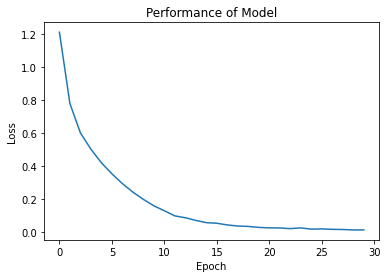

In [14]:
plt.plot(n_epochs, train_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model")
plt.show()

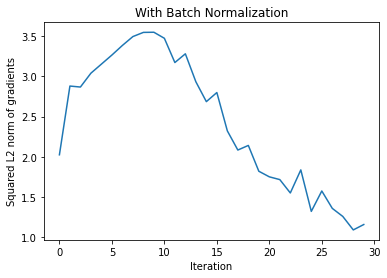

In [15]:
plt.plot(avg_gradient_norms)
plt.xlabel("Iteration")
plt.ylabel("Squared L2 norm of gradients")
plt.title("With Batch Normalization")
plt.show()

In [16]:
model_bn.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [17]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model_bn.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_bn(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.590321

Test Accuracy of airplane: 82% (821/1000)
Test Accuracy of automobile: 90% (903/1000)
Test Accuracy of  bird: 62% (621/1000)
Test Accuracy of   cat: 57% (577/1000)
Test Accuracy of  deer: 70% (707/1000)
Test Accuracy of   dog: 77% (770/1000)
Test Accuracy of  frog: 93% (931/1000)
Test Accuracy of horse: 84% (848/1000)
Test Accuracy of  ship: 90% (906/1000)
Test Accuracy of truck: 90% (907/1000)

Test Accuracy (Overall): 79% (7991/10000)


(1). Comparison between models without and with Batch Normalization:

I experimented with three groups of learning rates with both models. We can see from the results that models using batch normalization have higher accuracy overall compared to those without batch normalization models. 

|             | Accuracy Without Batch  | Accuracy With Batch      |
| :---        | :---                   | :---          |
| Lr=0.1      | 75%                  | 78%   |
| Lr=0.01     | 72%                  | 82%     |
| Lr=0.001    | 12%                  | 75%      |

(2). Plot the squared L2 norm of gradients with respect to parameters over the course of training with and without batch normalization.

For the plot of the model without using batch normalization, we can find the squared L2 norm of gradients getting larger as iterations progress.  It can indicate that the variance of the gradient is increasing so that the training of this model is not stable. On the other hand,  although the squared L2 norm of gradients of the model using batch normalization also becomes larger in the first few epochs, it starts to decrease over time and eventually level off. Therefore, we can find that batch normalization can make our model more stable and reduce the risk of overfitting. 

# 2. Residual connections (2 points)

Please make use of the model code from Homework 5 question 2 as you work on this question.

If your model didn't use residual connections, add them. If it already had residual connections, remove them. How does the performance change? Please experiment with applying residual connections around different blocks, where a block is a subset of layers (for example, add a residual connection around a single convolution/nonlinearity combination, or a residual connection around two convolution/nonlinearity combinations). Note that you may need to add 1x1 convolutions in the residual path if your block changes the shape (spatial or number of channels) of the input.

*   I added residual connections to my HW5 assignment, where the performance of the models did not differ much between the three models. This actually did not meet my expectations, as usually using residual connections should improve the accuracy of the model and enable the creation of deeper architectures.


|             | Without RC  | Model1      | Model2      |
| :---        | :---                   | :---          |:---          |
| Accuracy      | 82%                  | 81%   | 80%   |
| Test Loss     | 0.59                 | 0.62     | 0.61     |

In [18]:
# add residual connection around a single convolution/nonlinearity combination (Model1)
class ResNet(nn.Module):
   

    def __init__(self):
        
        super(ResNet, self).__init__()

        self.conv_layer1 = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.residual1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=2)
        
        self.conv_layer2 = nn.Sequential(
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),
        )

        self.residual2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=2)
        
        self.conv_layer3 = nn.Sequential(
            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers with residual connection
        residual = self.residual1(self.conv_layer1(x))
        x = self.conv_layer1(x)
        x += F.interpolate(residual, size=x.size()[2:], mode='nearest')
        
        # conv layers with residual connection
        residual = self.residual2(self.conv_layer2(x))
        x = self.conv_layer2(x)
        x += F.interpolate(residual, size=x.size()[2:], mode='nearest')
        
        # conv layers
        x = self.conv_layer3(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

# create a complete CNN
model1 = ResNet()
print(model1)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model1.cuda()

ResNet(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (residual1): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
  (conv_layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout2d(p=0.05, inplace=False)
  )
  (residual2): Conv2d(128, 128, kernel_size=(1, 1), stride

In [19]:
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model1.parameters(), lr=0.01)

In [20]:
# number of epochs to train the model
n_epochs = [*range(30)]
#List to store loss to visualize
train_losslist = []
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, len(n_epochs)+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model1.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model1(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################    
    # validate the model #
    ######################
    model1.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model1(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losslist.append(train_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model1.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.230403 	Validation Loss: 0.243030
Validation loss decreased (inf --> 0.243030).  Saving model ...
Epoch: 2 	Training Loss: 0.806492 	Validation Loss: 0.172730
Validation loss decreased (0.243030 --> 0.172730).  Saving model ...
Epoch: 3 	Training Loss: 0.626716 	Validation Loss: 0.151365
Validation loss decreased (0.172730 --> 0.151365).  Saving model ...
Epoch: 4 	Training Loss: 0.517759 	Validation Loss: 0.141569
Validation loss decreased (0.151365 --> 0.141569).  Saving model ...
Epoch: 5 	Training Loss: 0.433849 	Validation Loss: 0.169960
Epoch: 6 	Training Loss: 0.371834 	Validation Loss: 0.126180
Validation loss decreased (0.141569 --> 0.126180).  Saving model ...
Epoch: 7 	Training Loss: 0.308276 	Validation Loss: 0.133444
Epoch: 8 	Training Loss: 0.257848 	Validation Loss: 0.126602
Epoch: 9 	Training Loss: 0.214282 	Validation Loss: 0.128865
Epoch: 10 	Training Loss: 0.175980 	Validation Loss: 0.125085
Validation loss decreased (0.126180 --> 0.125085)

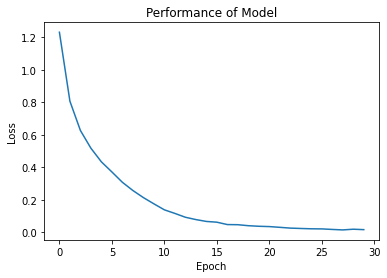

In [21]:
plt.plot(n_epochs, train_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model")
plt.show()

In [22]:
model1.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [23]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model1.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model1(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.623127

Test Accuracy of airplane: 81% (813/1000)
Test Accuracy of automobile: 91% (918/1000)
Test Accuracy of  bird: 79% (799/1000)
Test Accuracy of   cat: 68% (681/1000)
Test Accuracy of  deer: 83% (837/1000)
Test Accuracy of   dog: 69% (691/1000)
Test Accuracy of  frog: 82% (825/1000)
Test Accuracy of horse: 83% (834/1000)
Test Accuracy of  ship: 89% (894/1000)
Test Accuracy of truck: 83% (836/1000)

Test Accuracy (Overall): 81% (8128/10000)


In [24]:
# Add residual connection around two convolution/nonlinearity combinations (Model2)
# class ResNet2(nn.Module):
   

#     def __init__(self):
        
#         super(ResNet2, self).__init__()

#         self.conv_layer_1 = nn.Sequential(

#             # Conv Layer block 1
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )

#         self.conv_layer_2 = nn.Sequential(
#             # Conv Layer block 2
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Dropout2d(p=0.05)
#         )

#         # Residual Connection
#         self.residual_connection = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=2)

#         self.conv_layer_3 = nn.Sequential(
#             # Conv Layer block 3
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )

#         self.fc_layer = nn.Sequential(
#             nn.Dropout(p=0.1),
#             nn.Linear(4096, 1024),
#             nn.ReLU(inplace=True),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.1),
#             nn.Linear(512, 10)
#         )


#     def forward(self, x):
#         """Perform forward."""
        
#         # conv layers
#         x = self.conv_layer_1(x)
        
#         x = self.conv_layer_2(x)

#         # Residual Connection
#         residual = self.residual_connection(x)
#         # add residual to output of layer block 2
#         x = x + F.interpolate(residual, size=x.size()[2:], mode='nearest')
        
#         x = self.conv_layer_3(x)
        
#         # flatten
#         x = x.view(x.size(0), -1)
        
#         # fc layer
#         x = self.fc_layer(x)

#         return x

# # create a complete CNN
# model2 = ResNet2()
# print(model2)

# # move tensors to GPU if CUDA is available
# if train_on_gpu:
#     model2.cuda()

ResNet2(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout2d(p=0.05, inplace=False)
  )
  (